# Experiment management
This kernel is a fork of @artgor kernel https://www.kaggle.com/artgor/eda-and-models, thank you so much Andrew!

I've added experiment management functionality by tracking:
- data/feature versions

![image1](https://gist.githubusercontent.com/jakubczakon/f754769a39ea6b8fa9728ede49b9165c/raw/d0c079a7076c2292d38ab78cfa0947bdfc4d35b5/kaggle_properties.png)

- hyperparameters

![image2](https://gist.githubusercontent.com/jakubczakon/f754769a39ea6b8fa9728ede49b9165c/raw/d0c079a7076c2292d38ab78cfa0947bdfc4d35b5/kaggle_parameters.png)

- metrics

![image3](https://gist.githubusercontent.com/jakubczakon/f754769a39ea6b8fa9728ede49b9165c/raw/d0c079a7076c2292d38ab78cfa0947bdfc4d35b5/kaggle_metrics.png)

- diagnostic charts like confusion matrix, roc auc curve, or prediction distributions 

![image4](https://gist.githubusercontent.com/jakubczakon/f754769a39ea6b8fa9728ede49b9165c/raw/d0c079a7076c2292d38ab78cfa0947bdfc4d35b5/kaggle_images.png)

- prediction artifacts 

![image5](https://gist.githubusercontent.com/jakubczakon/f754769a39ea6b8fa9728ede49b9165c/raw/d0c079a7076c2292d38ab78cfa0947bdfc4d35b5/kaggle_artifacts.png)

- environment

![image6](https://gist.githubusercontent.com/jakubczakon/f754769a39ea6b8fa9728ede49b9165c/raw/d0c079a7076c2292d38ab78cfa0947bdfc4d35b5/kaggle_environment.png)

- code

![image7](https://gist.githubusercontent.com/jakubczakon/f754769a39ea6b8fa9728ede49b9165c/raw/d0c079a7076c2292d38ab78cfa0947bdfc4d35b5/kaggle_code.png)

As an added bonus you can learn how to add live monitoring for lightgbm model.

![image8](https://gist.githubusercontent.com/jakubczakon/f754769a39ea6b8fa9728ede49b9165c/raw/d0c079a7076c2292d38ab78cfa0947bdfc4d35b5/kaggle_charts.png)

All of those are tracked and organized in [Neptune](http://bit.ly/2XQYNgl). 

If you would like to see all my experiments in my public project [go here](https://ui.neptune.ai/jakub-czakon/ieee-fraud-detection/experiments). 

I figured I'd hide the pieces that were exactly the same as in the original kernel and focus on the extras.

In [ ]:
!pip install neptune-client neptune-contrib

## Imports

In [ ]:
import os

import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

import neptune
from neptunecontrib.monitoring.lightgbm import neptune_monitor
from neptunecontrib.versioning.data import log_data_version
from neptunecontrib.monitoring.reporting import send_binary_classification_report

# Data loading

In [2]:
raw_data_path = '../input/'
nrows = 10000

train_identity = pd.read_csv(f'{raw_data_path}train_identity.csv',nrows=nrows)
train_transaction = pd.read_csv(f'{raw_data_path}train_transaction.csv',nrows=nrows)
test_identity = pd.read_csv(f'{raw_data_path}test_identity.csv',nrows=nrows)
test_transaction = pd.read_csv(f'{raw_data_path}test_transaction.csv',nrows=nrows)
sub = pd.read_csv(f'{raw_data_path}sample_submission.csv',nrows=nrows)
# let's combine the data and work with the whole dataset
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 10000 rows and 434 columns.
Test dataset has 10000 rows and 433 columns.


# Feature engineering

In [3]:
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')

train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')


train['dist1_to_mean_card1'] = train['dist1'] / train.groupby(['card1'])['dist1'].transform('mean')
train['dist1_to_mean_card4'] = train['dist1'] / train.groupby(['card4'])['dist1'].transform('mean')
train['dist1_to_std_card1'] = train['dist1'] / train.groupby(['card1'])['dist1'].transform('std')
train['dist1_to_std_card4'] = train['dist1'] / train.groupby(['card4'])['dist1'].transform('std')

test['dist1_to_mean_card1'] = test['dist1'] / test.groupby(['card1'])['dist1'].transform('mean')
test['dist1_to_mean_card4'] = test['dist1'] / test.groupby(['card4'])['dist1'].transform('mean')
test['dist1_to_std_card1'] = test['dist1'] / test.groupby(['card1'])['dist1'].transform('std')
test['dist1_to_std_card4'] = test['dist1'] / test.groupby(['card4'])['dist1'].transform('std')


train['D4_to_mean_card1'] = train['D4'] / train.groupby(['card1'])['D4'].transform('mean')
train['D4_to_mean_card4'] = train['D4'] / train.groupby(['card4'])['D4'].transform('mean')
train['D4_to_std_card1'] = train['D4'] / train.groupby(['card1'])['D4'].transform('std')
train['D4_to_std_card4'] = train['D4'] / train.groupby(['card4'])['D4'].transform('std')

test['D4_to_mean_card1'] = test['D4'] / test.groupby(['card1'])['D4'].transform('mean')
test['D4_to_mean_card4'] = test['D4'] / test.groupby(['card4'])['D4'].transform('mean')
test['D4_to_std_card1'] = test['D4'] / test.groupby(['card1'])['D4'].transform('std')
test['D4_to_std_card4'] = test['D4'] / test.groupby(['card4'])['D4'].transform('std')

train['card1_count'] = train.groupby(['card1'])['TransactionID'].transform('count')
train['card2_count'] = train.groupby(['card2'])['TransactionID'].transform('count')
train['card4_count'] = train.groupby(['card4'])['TransactionID'].transform('count')

test['card1_count'] = test.groupby(['card1'])['TransactionID'].transform('count')
test['card2_count'] = test.groupby(['card2'])['TransactionID'].transform('count')
test['card4_count'] = test.groupby(['card4'])['TransactionID'].transform('count')

In [4]:
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

In [5]:
big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [6]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
one_value_cols == one_value_cols_test

False

In [7]:
cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols+ one_value_cols_test))
len(cols_to_drop)

154

In [8]:
cols_to_drop.remove('isFraud')

In [9]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [10]:
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']
for col in cat_cols:
    if col in train.columns:
        train = train.drop([col], axis=1)
        test = test.drop([col], axis=1)

It is usually beneficial save extracted features for future reference and also to easily calculate feature versions.

In [11]:
features_data_path = '../output/features/'
os.makedirs(features_data_path, exist_ok=True)

train_features_path = f'{features_data_path}train_features_v0.csv'
test_features_path = f'{features_data_path}test_features_v0.csv'

train.to_csv(train_features_path, index=None)
test.to_csv(test_features_path, index=None)

In [16]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
X_test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

train = train[["TransactionDT", 'TransactionID']]
test = test[["TransactionDT", 'TransactionID']]

# Modeling

In [12]:
validation_params = {'seed':1234,
                     'n_folds':5,
                     'validation_schema': 'kfold'}

folds = KFold(n_splits=validation_params['n_folds'], random_state=validation_params['seed'])

In [13]:
model_params = {'num_leaves': 256,
                  'min_child_samples': 79,
                  'objective': 'binary',
                  'max_depth': 15,
                  'learning_rate': 0.02,
                  "boosting_type": "gbdt",
                  "subsample_freq": 3,
                  "subsample": 0.9,
                  "bagging_seed": 11,
                  "metric": 'auc',
                  "verbosity": -1,
                  'reg_alpha': 0.3,
                  'reg_lambda': 0.3,
                  'colsample_bytree': 0.9
                 }

training_params = {'num_boosting_rounds':5000,
                   'early_stopping_rounds':200
               }

Let's combine all the parameters in one big hyperparameter dictionary.

In [ ]:
hyperparameters={**model_params, **training_params,**validation_params}

And let's define the fit_predict function that will train the model and return predictions.
Following advice from CMPM I want to keep the scores both on train and validation to measure my generalization gap.

In [15]:
def fit_predict(X, y, X_test, folds, model_params, training_params):
    in_fold, out_of_fold, test_preds = np.zeros(len(X)), np.zeros(len(X)), np.zeros(len(X_test))
    for fold_nr, (trn_idx, val_idx) in enumerate(folds.split(X.values, y.values)):
        print("Fold {}".format(fold_nr))

        X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        trn_data = lgb.Dataset(X_train, y_train)
        val_data = lgb.Dataset(X_valid, y_valid)
        
        # add live monitoring of lightgbm learning curves
        monitor = neptune_monitor(prefix='fold{}_'.format(fold_nr))
        clf = lgb.train(model_params, trn_data, 
                        training_params['num_boosting_rounds'], 
                        valid_sets = [trn_data, val_data], 
                        early_stopping_rounds = training_params['early_stopping_rounds'],
                        callbacks=[monitor])
        in_fold[trn_idx] = clf.predict(X.iloc[trn_idx], num_iteration=clf.best_iteration)
        out_of_fold[val_idx] = clf.predict(X.iloc[val_idx], num_iteration=clf.best_iteration)
        test_preds += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits
    return in_fold, out_of_fold, test_preds    

def fmt_preds(y_pred):
    return np.concatenate((1.0-y_pred.reshape(-1,1), y_pred.reshape(-1,1)), axis=1)

# Adding Experiment management 

Now, you need to initialize Neptune with the api token and project name.
For now I will use open token and a public shared project but if you register you can create private project for you and your team (for free).

In [2]:
neptune.init(api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5tbCIsImFwaV9rZXkiOiJiNzA2YmM4Zi03NmY5LTRjMmUtOTM5ZC00YmEwMzZmOTMyZTQifQ==',
             project_qualified_name='shared/showroom')

Project(shared/showroom)

You can also pass NEPTUNE_PROJECT and NEPTUNE_API_TOKEN as environment variables.

In notebooks you can do it by running:
    
```bash
% env NEPTUNE_API_TOKEN=eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5tbCIsImFwaV9rZXkiOiJiNzA2YmM4Zi03NmY5LTRjMmUtOTM5ZC00YmEwMzZmOTMyZTQifQ==
% env NEPTUNE_PROJECT=shared/showroom
```

and then you will be able to simply run

```python
neptune.init()
```

Whenever you run `neptune.create_experiment` a link to an experiment is created and you can go and see your experiment.
Example link looks like this https://ui.neptune.ai/o/shared/org/showroom/e/SHOW-23

SHOW-17
https://ui.neptune.ai/shared/showroom/e/SHOW-17
Fold 0
[1]	training's auc: 0.900317	valid_1's auc: 0.680362
Training until validation scores don't improve for 2 rounds.
[2]	training's auc: 0.920729	valid_1's auc: 0.715316
Did not meet early stopping. Best iteration is:
[2]	training's auc: 0.920729	valid_1's auc: 0.715316
Fold 1
[1]	training's auc: 0.894653	valid_1's auc: 0.78921
Training until validation scores don't improve for 2 rounds.
[2]	training's auc: 0.908838	valid_1's auc: 0.810272
Did not meet early stopping. Best iteration is:
[2]	training's auc: 0.908838	valid_1's auc: 0.810272
Fold 2
[1]	training's auc: 0.881392	valid_1's auc: 0.7917
Training until validation scores don't improve for 2 rounds.
[2]	training's auc: 0.910479	valid_1's auc: 0.813597
Did not meet early stopping. Best iteration is:
[2]	training's auc: 0.910479	valid_1's auc: 0.813597
Fold 3
[1]	training's auc: 0.897144	valid_1's auc: 0.721612
Training until validation scores don't improve for 2 rounds.
[

/home/jakub/miniconda3/envs/py_36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


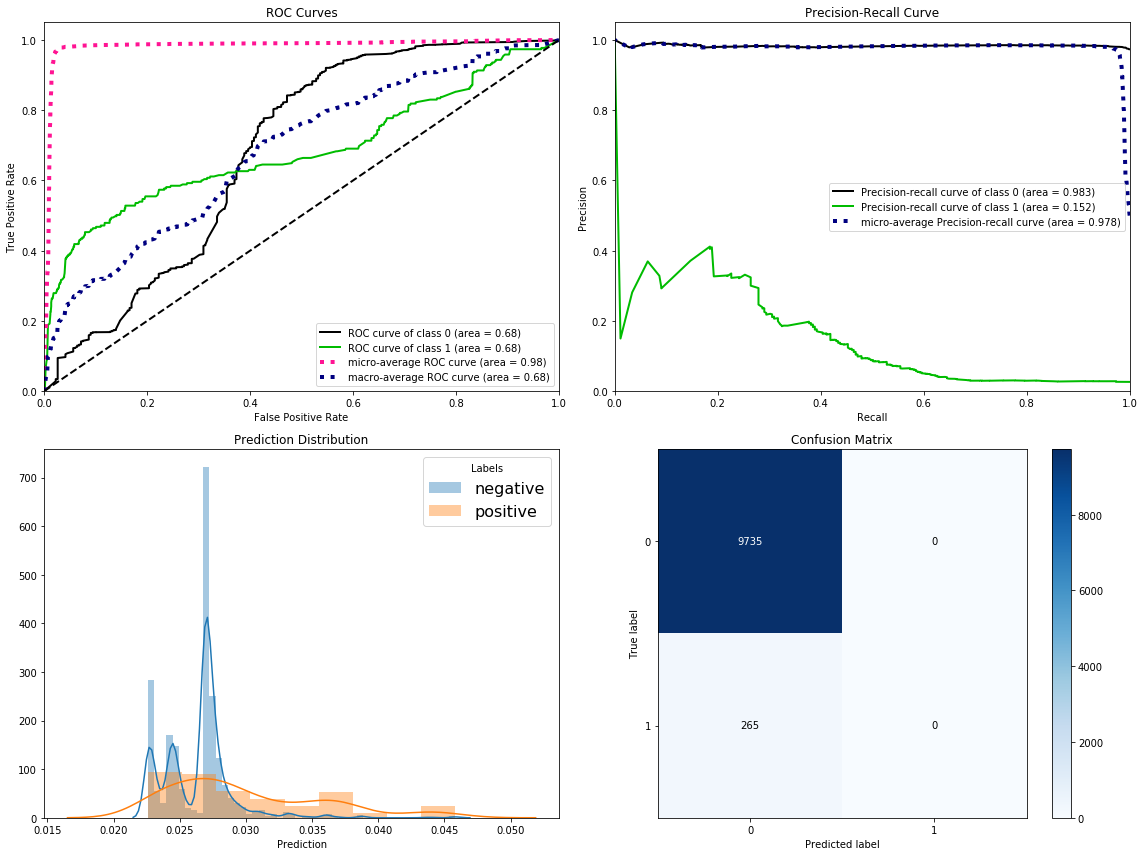

In [23]:
predictions_data_path = '../output/predictions/'
os.makedirs(predictions_data_path, exist_ok=True)

train_predictions_path = f'{predictions_data_path}train_predictions_v0.csv'
test_predictions_path = f'{predictions_data_path}test_predictions_v0.csv'
submission_path = f'{predictions_data_path}submission_v0.csv'

with neptune.create_experiment(name='model training',
                               params=hyperparameters,
                               tags=['lgbm', 'features_v0', 'training']):
    # log data versions
    log_data_version(train_features_path, prefix='train_features_')
    log_data_version(test_features_path, prefix='test_features_')

    in_fold, out_of_fold, test_preds = fit_predict(X, y, X_test, folds, model_params, training_params)
    
    train_auc, valid_auc = roc_auc_score(y, in_fold), roc_auc_score(y, out_of_fold)
    # log train and valid auc metrics
    neptune.send_metric('train_auc', train_auc)
    neptune.send_metric('valid_auc', valid_auc)
    # log diagnostic charts on the validation
    send_binary_classification_report(y, fmt_preds(out_of_fold), channel_name='valid_classification_report')
    
    train = pd.concat([train, pd.DataFrame(out_of_fold, columns=['prediction'])], axis=1)
    test = pd.concat([test, pd.DataFrame(test_preds, columns=['prediction'])], axis=1)
    sub['isFraud'] = pd.merge(sub, test, on='TransactionID')['prediction']
    train.to_csv(train_predictions_path, index=None)
    test.to_csv(test_predictions_path, index=None)
    sub.to_csv(submission_path, index=None)
    # log out of fold predictions and submission
    neptune.send_artifact(train_predictions_path)
    neptune.send_artifact(test_predictions_path)
    neptune.send_artifact(submission_path)